# Imports

In [1]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, roc_auc_score, roc_curve
import pandas as pd
import pickle
import matplotlib.pyplot as plt

# Load Data and Models

In [2]:
# Load training and test data
X_train = pd.read_csv("/kaggle/input/ibm-classification-feature-selection/X_train_normalized.csv", index_col=[0])
X_test = pd.read_csv("/kaggle/input/ibm-classification-feature-selection/X_test_normalized.csv", index_col=[0])
y_train = pd.read_csv("/kaggle/input/ibm-classification-feature-selection/y_train.csv", index_col=[0])
y_test = pd.read_csv("/kaggle/input/ibm-classification-feature-selection/y_test.csv", index_col=[0]).reset_index(drop=True)

In [3]:
# Load models
model_paths = [
    '/kaggle/input/ibm-classification-logistic-regression/lr_model.pkl',
    '/kaggle/input/ibm-classification-xgboost/xgb_model.pkl',
]
models = []
for p in model_paths:
    with open(p, 'rb') as file:
        models.append(pickle.load(file))


# Get mapping from index of list to name of model
model_map = {
    0: 'Logistic Regression',
    1: 'XGBoost',
    2: 'SVM'
}

# Get number of models for ease
num_models = len(models)

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [08:41:33] WARNING: /workspace/src/gbm/gbtree.cc:385: Changing updater from `grow_gpu_hist` to `grow_quantile_histmaker`.
  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [08:41:33] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


# Results Analysis

### Make Predictions

In [4]:
# Make predictions on test set
y_pred = [m.predict(X_test) for m in models]

# Make predicitions on training set to test for overfitting
y_pred_train = [m.predict(X_train) for m in models]

### Confusion Matrix
The confusion matrix shows us how our predicted labels compare to our actual labels.

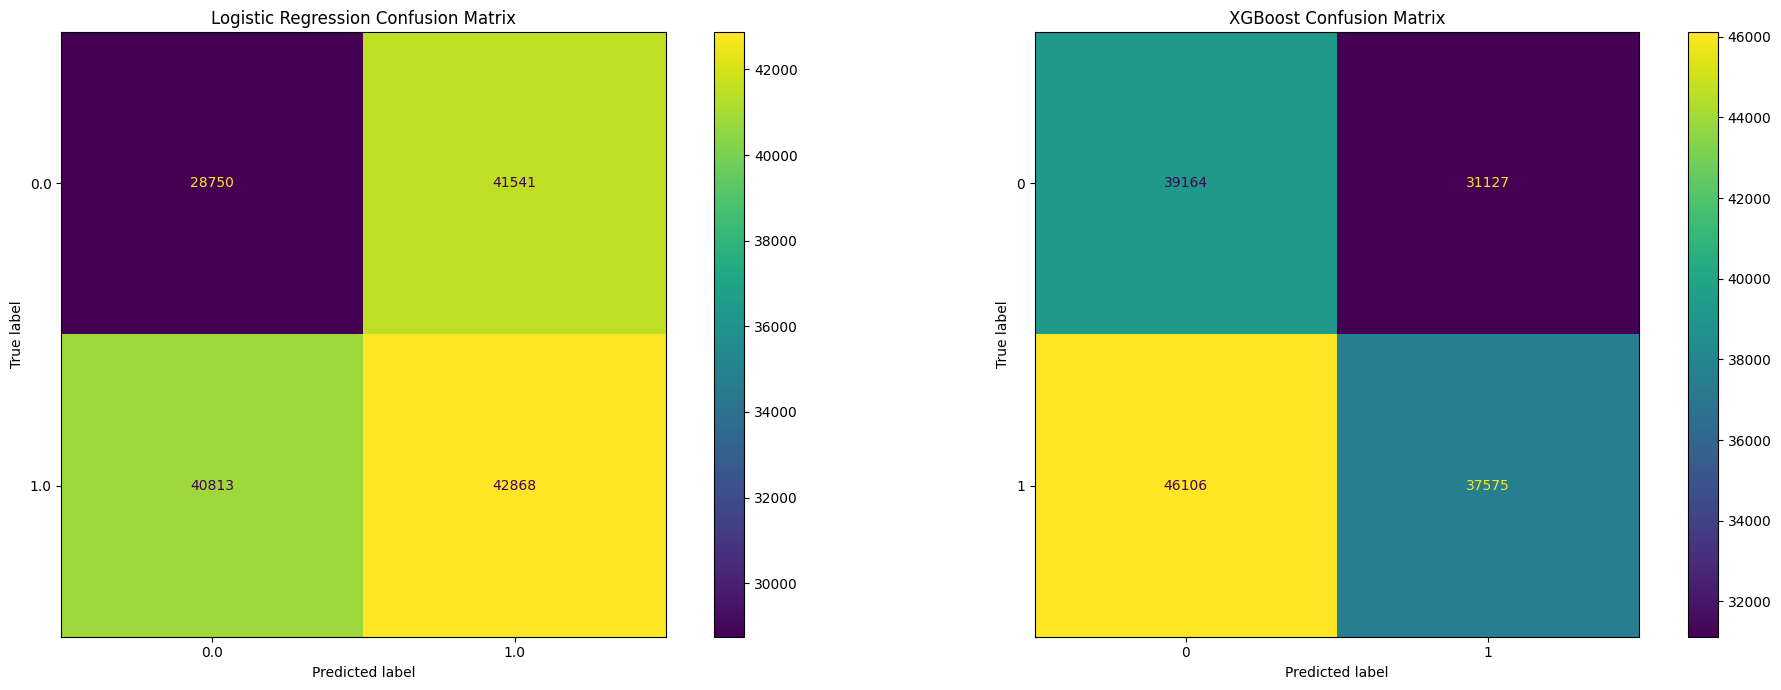

In [5]:
#################################
# Plot confusion matrices
#################################

# Set up subplot
fig, axes = plt.subplots(nrows=1, ncols=num_models, figsize=(20, 7))

# Plot
for i, m in enumerate(models):
    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred[i])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=m.classes_) # Note not every model may have this classes_ property
    
    # Plot
    disp.plot(ax=axes[i], cmap='viridis')
    axes[i].set_title(f'{model_map[i]} Confusion Matrix')
    
# Adjust layout and show plot
plt.tight_layout()
plt.show()

### Accuracy, Precision, Recall, F1-Score
* **Accuracy**: Measure of how good the classifier is at predicting correctly. It's simply the number of predictions the classifier got right divided by the total number of predicitions it made. In the confusion, matrix, it's the sum of the leading diagonal divided by the sum of the whole matrix.

* **Precision**: For a given class, this measures how good the classifier is at not incorrectly labelling something as the class. For the given class, it's simply the number of predictions that were correctly labelled as that class divided by the total number of predictions that were labelled with that class.

* **Recall**: For a given class, this measures how good the classifier is at correctly labelling something as that class. For the given class, it's simply the number of predictions that were correctly labelled as that class divided by the total number of actual instances of that class.

* **F1-Score**: For a given class, this is a weighted harmonic mean of precision and recall where each are given equal importance. The best F1-score is 1 and the worst is 0.

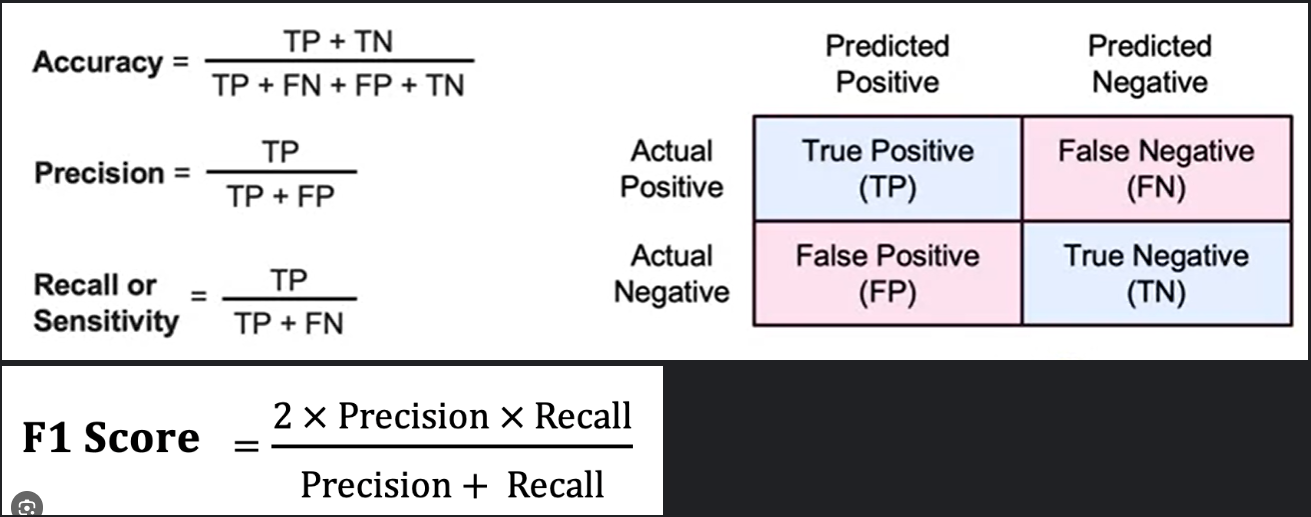

In [6]:
# Accuracy
for i in range(num_models):
    accuracy_test = accuracy_score(y_test, y_pred[i])
    accuracy_train = accuracy_score(y_train, y_pred_train[i])
    print(f"{model_map[i]} Test Accuracy {accuracy_test}")
    print(f"{model_map[i]} Training Accuracy {accuracy_train}")
    print("\n")

Logistic Regression Test Accuracy 0.4651365183280077
Logistic Regression Training Accuracy 0.5824834302504874


XGBoost Test Accuracy 0.4983958122255995
XGBoost Training Accuracy 0.6521435902626331




In [7]:
# Classification report showing precision, recall and F1 score for each class, as well accuracy and some averages
for i in range(num_models):
    cr = classification_report(y_test, y_pred[i], digits=3)
    print(f"{model_map[i]}")
    print(cr)
    print("\n")

Logistic Regression
              precision    recall  f1-score   support

         0.0      0.413     0.409     0.411     70291
         1.0      0.508     0.512     0.510     83681

    accuracy                          0.465    153972
   macro avg      0.461     0.461     0.461    153972
weighted avg      0.465     0.465     0.465    153972



XGBoost
              precision    recall  f1-score   support

         0.0      0.459     0.557     0.504     70291
         1.0      0.547     0.449     0.493     83681

    accuracy                          0.498    153972
   macro avg      0.503     0.503     0.498    153972
weighted avg      0.507     0.498     0.498    153972





### ROC Curve

Remember that the Logistic Regression algorithm uses probabilities to predict the class of a sample. For example, if the probability the sample belongs to class A is greater than 0.5 then it will be classified as Class A and if it's less than 0.5 it will be classified as Class B. This probability (0.5 in this case) is called the 'classification threshold'. A higher/lower classification threshold can change which data samples get classified as each class.

The Receiver Operating Characteristic (ROC) curve plots the True Positive Rate (aka. recall) against the False Positive Rate for varying levels of this classification threshold. As shown in the image below, TPR is simply the number of true positives relative to the total number of positives and FPR is the number of false positives relative to the total number of negatives. 

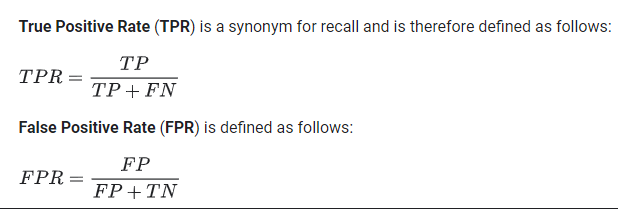

A typical ROC curve is shown below. The classification threshold is DECREASING from left to right. As we decrease the classification threshold, we classify more items as postiive, hence increasing both true positives and false positives.

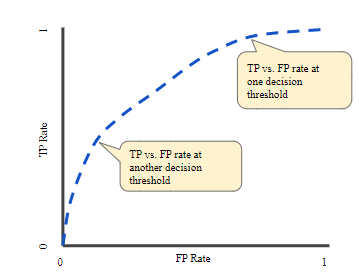

Note to plot this curve, we would need to train a model and then vary the classification threshold between 0 and 1 and calculate the TPR and FPR for each one.

### AUC

AUC stands for area under the ROC curve. It gives us an aggregate measure of performance across all classification thresholds. Since TPR and FPR are between 0 and 1, the value of AUC is also between 0 and 1.

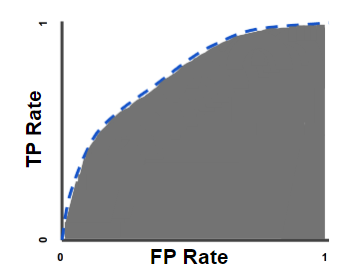

We can interpret AUC as the probability that a random positive example is assigned a higher probability by the regression model than a random negative sample. If the predictions are 100% correct, AUC will be 1 and if they're 100% wrong it will be 0. If the AUC is 0.5 then the model makes predicitions no better than random guessing.

Logistic Regression AUC is 0.44440812911178146
XGBoost AUC is 0.5019825930850939


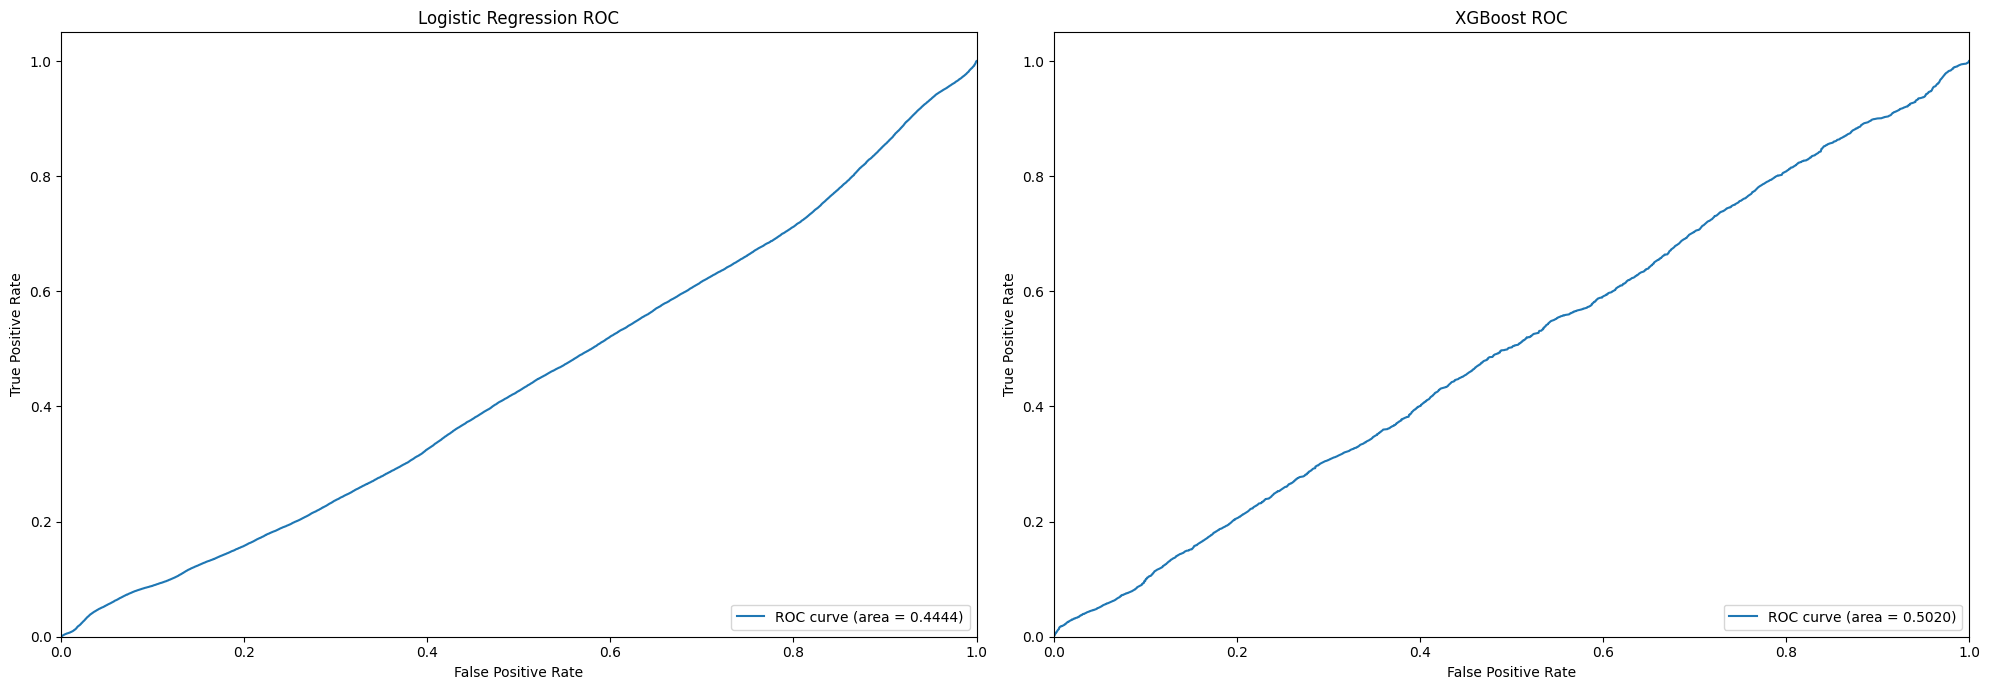

In [8]:
# Import
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Setup subplots
fig, axes = plt.subplots(nrows=1, ncols=num_models, figsize=(20, 7))

# Get probabilities of positive class - need to think about this as svm doesan't output probabilities for example
for i, m in enumerate(models):
    y_pred_prob = m.predict_proba(X_test)[:, 1]

    # Compute roc curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

    # Compute AUC
    auc = roc_auc_score(y_test, y_pred_prob)
    print(f"{model_map[i]} AUC is {auc}")

    # Plot ROC curve
    ax = axes[i]
    ax.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % auc)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'{model_map[i]} ROC')
    ax.legend(loc="lower right")

# Adjust layout and show plot
plt.tight_layout()
plt.show()

# Strategies